In [2]:
import torch
from torch import nn

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Method

In [3]:
class RelativeEstimator(nn.Module):
    def __init__(self, n_groups, n_attributes):
        super().__init__()
        self.n_groups = n_groups
        self.n_attributes =  n_attributes
        self.c_g_coeffs = nn.Parameter(torch.randn((n_groups, 1), requires_grad=True, dtype=torch.float))
        #self.c_g_coeffs = []
        self.real_c_g_coeffs = []
        self.real_c_g_coeffs = torch.Tensor([[.5], [.75]]).cuda()
        self.p_y_coeffs = nn.Parameter(torch.randn((n_attributes, 1), requires_grad=True, dtype=torch.float))
        self.p_y_bias = nn.Parameter(torch.randn((n_attributes, 1), requires_grad=True, dtype=torch.float))
        
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # x : a N x (n_groups + n_features) matrix, where the first 
        # n_groups features is a one-hot encoding of the patient's group
        # and the subsequent n_features features are the patient's attributes
        
        group_features = x[:,:self.n_groups]
        class_attributes = x[:,self.n_groups:]
        if not len(self.real_c_g_coeffs):
            c_pred = self.sigmoid(torch.mm(group_features,self.c_g_coeffs))
        else:
            c_pred = torch.mm(group_features, self.real_c_g_coeffs)
        p_y_pred = self.sigmoid(torch.mm(class_attributes,self.p_y_coeffs) + self.p_y_bias)
        return c_pred * p_y_pred
    
    def estimate_ratio(self, g1_attributes, g2_attributes):
        # find indices for g2 
        n_g1 = len(g1_attributes)
        n_g2 = len(g2_attributes)
        print(g1_attributes.shape, g2_attributes.shape)
        p_y_g1 = self.sigmoid(torch.mm(g1_attributes, self.p_y_coeffs) + self.p_y_bias)
        p_y_g2 = self.sigmoid(torch.mm(g2_attributes, self.p_y_coeffs) + self.p_y_bias)
        # sum and divide by 
        print(torch.sum(p_y_g1)/n_g1)
        print(torch.sum(p_y_g2)/n_g2)
        relative_prevalence = (torch.sum(p_y_g1)/n_g1) / (torch.sum(p_y_g2)/n_g2)
        return relative_prevalence
    
    def get_c_g(self):
        if not len(self.real_c_g_coeffs):
            c_pred = self.sigmoid(self.c_g_coeffs)
            return c_pred
        return self.real_c_g_coeffs

# Covariate Shift

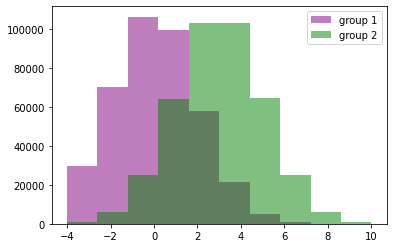

In [4]:
# univariate; different groups have different means, but the same decision rule
# for starters, we're assuming c1 = c2
n_groups = 2
n_attributes = 1
n_to_sample = 400000

g1_mean = 0
g2_mean = 3
std = 2
thresh = -.5
epsilon = .5
c1 = .75
c2 = .5

# simulate population 1 attributes & labels
g1_attributes = np.expand_dims(np.random.normal(g1_mean, std, n_to_sample), axis=1)
y1 = (g1_attributes < thresh).astype(int)
y1_pos_idxs = np.where(y1 == 1)[0]
s1 = np.zeros(y1.shape)
labeled_idxs = np.random.choice(y1_pos_idxs, int(len(y1_pos_idxs)*c1), replace=False)
s1[labeled_idxs] = 1

# simulate population 2 attributes & labels
g2_attributes = np.expand_dims(np.random.normal(g2_mean, std, n_to_sample), axis=1)
y2 = (g2_attributes < thresh).astype(int)
y2_pos_idxs = np.where(y2 == 1)[0]
s2 = np.zeros(y2.shape)
labeled_idxs = np.random.choice(y2_pos_idxs, int(len(y2_pos_idxs)*c2), replace=False)
s2[labeled_idxs] = 1

# plot both populations
binrange = (-4, 10)
plt.hist(g1_attributes, alpha=.5, range=binrange, label='group 1', color='purple')
plt.hist(g2_attributes, alpha=.5, range=binrange, label='group 2', color='green')
plt.legend()

# concatenate with group features
x1_features = np.concatenate((np.zeros((n_to_sample, n_groups)), g1_attributes), axis=1)
x2_features = np.concatenate((np.zeros((n_to_sample, n_groups)), g2_attributes), axis=1)
x1_features[:,0] = 1
x2_features[:,1] = 1

x = np.concatenate([x1_features, x2_features])
y = np.concatenate([y1, y2])
s = np.concatenate([s1, s2])

y = np.squeeze(y, axis=1)
s = np.squeeze(s, axis=1)

# Create more separation
greater_than = x[:,2] > (thresh - epsilon)
less_than = x[:,2] < (thresh + epsilon)
drop_idxs = np.array([a and b for a,b in zip(greater_than, less_than)])

x = x[~drop_idxs,:]
y = y[~drop_idxs]
s = s[~drop_idxs]

In [5]:
# Create more separation
greater_than = x[:,2] > (thresh - epsilon)
less_than = x[:,2] < (thresh + epsilon)
drop_idxs = np.array([a and b for a,b in zip(greater_than, less_than)])

x = x[~drop_idxs,:]
y = y[~drop_idxs]
s = s[~drop_idxs]

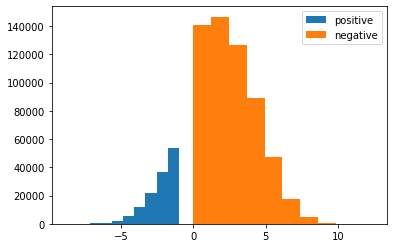

In [6]:
# Plot the decision rule and true labels
plt.hist(x[y==1,2], label= 'positive')
plt.hist(x[y!=1,2], label = 'negative')
plt.legend()

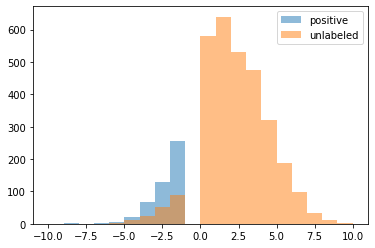

In [545]:
# Plot the decision rule and observed labels
plt.hist(x[s==1,2], label= 'positive', alpha=.5, range=(-10, 10), bins=20)
plt.hist(x[s!=1,2], label = 'unlabeled', alpha=.5, range=(-10, 10), bins=20)
plt.legend()

# Evaluation

In [539]:
# Split into train and test data
x_train, x_test, y_train, y_test, s_train, s_test = train_test_split(x, y, s, test_size=.2, 
                                                                     random_state=42, shuffle=True, stratify=y)


In [540]:
# train model
model = RelativeEstimator(n_groups, n_attributes)
optimizer = torch.optim.SGD(model.parameters(), lr=.1, momentum=.9, weight_decay=1e-4)
criterion = torch.nn.BCELoss()
model.cuda('cuda:0')
criterion.cuda('cuda:0')
model.train()

n_epochs = 7000
losses = []
x_tensor = torch.Tensor(x_train)
x_tensor = x_tensor.cuda()

for epoch in range(n_epochs):
    s_pred = model(x_tensor)
    loss = criterion(torch.squeeze(s_pred), torch.Tensor(s_train).cuda())
    
    #  Calculate accuracy
    
    losses.append(loss.item())
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()  

Text(0, 0.5, 'BCE')

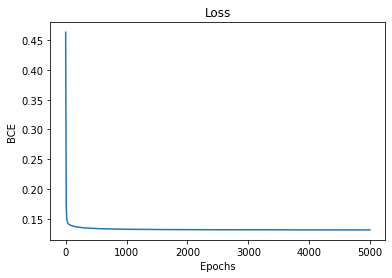

In [541]:
# visualize losses
plt.plot(list(range(n_epochs)), losses)
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("BCE")

In [542]:
g1_test_attributes = x_test[np.where(x_test[:,0] == 1)[0], 2]
g2_test_attributes = x_test[np.where(x_test[:,1] == 1)[0], 2]

g1_test_attributes = np.expand_dims(g1_test_attributes, 1)
g2_test_attributes = np.expand_dims(g2_test_attributes, 1)

y1_test = y_test[np.where(x_test[:,0] == 1)[0]]
y2_test = y_test[np.where(x_test[:,1] == 1)[0]]

g1_test_attributes = torch.Tensor(g1_test_attributes).cuda()
g2_test_attributes = torch.Tensor(g2_test_attributes).cuda()
ratio_estimate = model.estimate_ratio(g1_test_attributes, g2_test_attributes).item()
print(np.mean(y1_test), np.mean(y2_test))
print("Estimate of Relative Prevalence: ", ratio_estimate)
print("True Relative Prevalence: ", np.mean(y1_test)/np.mean(y2_test))
print("Group Labeling Frequencies: ", model.get_c_g().detach().cpu().numpy()[:,0])

torch.Size([318, 1]) torch.Size([390, 1])
tensor(0.3834, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0262, device='cuda:0', grad_fn=<DivBackward0>)
0.3836477987421384 0.02564102564102564
Estimate of Relative Prevalence:  14.645550727844238
True Relative Prevalence:  14.962264150943398
Group Labeling Frequencies:  [0.5  0.75]


# Debugging

(array([576.,   0.,   0.,   0.,   0.,   0., 122.,   0.,   0.,  10.]),
 array([1.5299301e-26, 7.4997745e-02, 1.4999549e-01, 2.2499324e-01,
        2.9999098e-01, 3.7498873e-01, 4.4998649e-01, 5.2498424e-01,
        5.9998196e-01, 6.7497975e-01, 7.4997747e-01], dtype=float32),
 <BarContainer object of 10 artists>)

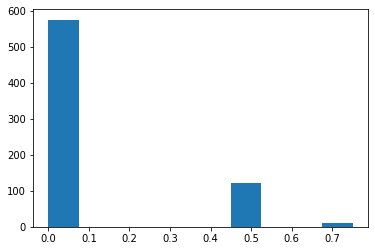

In [543]:
# How accurate is the model on g1 examples
# How accurate is model on g2 examples (aka what is throwing the ratio off)
from sklearn.metrics import roc_auc_score

x_test_tensor = torch.Tensor(x_test).cuda()
y_pred = model(x_test_tensor).detach().cpu().numpy()
plt.hist(y_pred)

# Label shift assumption - p(y) changes

In [ ]:
# each group has the same mean, but different distributions over x 
# same decision rule

